# Linear Virtual Element for Poisson Equation in 2D

This example is to show the rate of convergence of the linear virtual finite element approximation of the Poisson equation on the unit square:

$$- \Delta u = f \; \hbox{in } (0,1)^2$$

for the following boundary conditions
- Non-empty Dirichlet boundary condition: $u=g_D \hbox{ on }\Gamma_D, \nabla u\cdot n=g_N \hbox{ on }\Gamma_N.$


**References**:
- [Progamming of Linear Virtual Element Methods](http://www.math.uci.edu/~chenlong/226/vemCode.pdf)

**Subroutines**:

    - PoissonVEM
    - squarePoissonVEM
    
The method is implemented in `PoissonVEM` subroutine and tested in `squarePoissonVEM`.   

## Polygon Meshes

The polygonal mesh we used is generated by [*PolyMesher*](https://paulino.ce.gatech.edu/software.html) in MATLAB. The output contains a matrix named `Node` which represents the coordinates of vertices and a cell array named `Element` of which each cell records the vertices of each element with a counter-clockwise order. 

Polygon meshes used in this example are saved in data folder: `E16` to `E20014`.

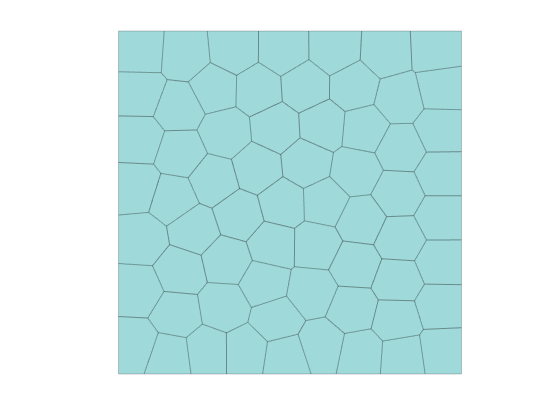

In [12]:
load E64;
showmeshpoly(Node,Element);

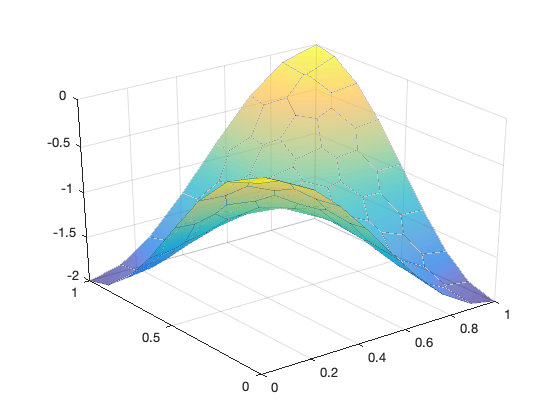

In [13]:
u = @(p)cos(pi*p(:,1)).*cos(pi*p(:,2))-1;
uI = u(Node);
showsolutionpoly(Node,Element,uI);

## P1 Linear Virtual Element

Let $\mathcal T_h$ be a collection of partitions of domain $\Omega$ into polygonal elements without self-intersecting boundary. The linear VEM space $V_h(E)$ for a polygon $E \in \mathcal T_h$ is defined as:
\begin{equation*}\label{VEMspace2}
V_h(E) := \{ v \in H^1(E): \Delta v|_E = 0, v|_{\partial E} \text{ is continuous and piecewise linear}  \}.
\end{equation*}
Namely restricted to boundary edges of a polygon, the function is the standard linear Lagrange element. The interior is defined by the harmonic extension. 
Since a piecewise linear function will be uniquely determined by its value on vertices, $\dim V_h(E)=n_E$, where $n_E$ is the number of vertices of $E$. 

The global virtual element space is defined as 
$$
V_h = \{v_h \in H^1(\Omega): v_h|_E \in V_h(E)\ \text{ for all}\ E \in \mathcal T_h\}.
$$

Let $\mathcal N(\mathcal T_h)$ be the set of vertices of mesh $\mathcal T_h$ and $N = |\mathcal N(\mathcal T_h)|$ be the number of vertices. 
We define the operator $\operatorname{dof}$ (degree of freedom) from $V_h$ to $\mathbb{R}^N$ as $\operatorname{dof}_i(v_h) = v_h(\boldsymbol  x_i)$, for a vertex $\boldsymbol  x_i\in \mathcal N(\mathcal T_h), i = 1,\ldots, N$. The canonical basis $\{\phi_1,\cdots, \phi_{N}\}$ of $V_h$ is chosen satisfying $\operatorname{dof}_i(\phi_j) = \delta_{ij},  i,j = 1, \cdots, N$.

A basis function $\phi_i$  is like the classical hat function of linear FE defined on triangular meshes. The difference is: for FEM functions, inside the element it is a linear polynomial while the VEM function is defined by the harmonic extension and function values inside the element is not explicitly known. The basis does not need to be known explicitly and this is the reason for the term *virtual* in VEM.

## Assembeling

To compute the stiffness matrix  $\mathbf {A}_{ij} = (\nabla \phi_j, \nabla \phi_i)$ in the Galerkin method, we need to know the basis functions. Instead, the local stiffness matrix of the virtual element method is split into two parts:
\begin{align}
(\mathbf {A}_h^E)_{ij}:= (\nabla \Pi^\nabla \phi_i, \nabla\Pi^\nabla \phi_j)_{E} + \sum_{r=1}^{n_E}{\operatorname{dof}}_{r}((I- \Pi^\nabla) \phi_i) \, {\operatorname{dof}}_r((I- \Pi^\nabla)\phi_j),
\label{eq:stiffmatrix1}
\end{align}

The operator $\Pi^\nabla : V_h(E) \rightarrow  \mathbb{P}_1(E)$ is an $H^1$ projection to $\mathbb{P}_1(E)$ space:
\begin{equation}\label{eq:projection}
(\nabla \Pi^\nabla v_h, \nabla p)_{E} = (\nabla v_h, \nabla p)_{E} \quad \text{ for all } p \in \mathbb{P}_1(E).
\end{equation}

The matrix representation of the projection is
$$ \mathbf {\Pi}^\nabla \mathbf  v = \mathbf  G^{-1} \mathbf  B \mathbf  v,$$
where we can chose the basis and the constraint to make $G = I$ and 
\begin{align*}
\mathbf {B} := &\begin{pmatrix}
1/n_E  & 1/n_E  & \cdots & 1/n_E\\
 (\nabla m_2,\nabla \phi_1)_{E}&  (\nabla m_2,\nabla \phi_2)_{E}& \cdots & (\nabla m_2,\nabla \phi_{n_E})_{E}\\
 (\nabla m_3,\nabla \phi_1)_{E}&  (\nabla m_3,\nabla \phi_2)_{E}& \cdots & (\nabla m_3,\nabla \phi_{n_E})_{E}
 \end{pmatrix}.
\end{align*}

The integral can be computed by integration by parts
\begin{align}
(\nabla m_{j},\nabla \phi_i)_{E} = \int_{\partial E}\nabla m_{j} \cdot \mathbf  n \, \phi_i \, {\rm d} s = \frac{1}{2h_E} (\mathbf  n_e^{j-1} + \mathbf  n_{e'}^{j-1}), 
\label{eq:matrixb1}
\end{align}
where $e$ and $e'$ are two edges containing the vertex $i$, the first $\mathbf n$ is the unit outwards normal vector of $\partial E$ and $\mathbf {n}_e=(n_e^x,n_e^y)=(n_e^1,n_e^2)$ is the scaled normal vector by multiplying the edge length. 

<img src="../figures/VEMgradient.png" width="40%">

In order to compute the stabilization term, introduce matrix $\mathbf {D}_{n_E\times 3}$
\begin{align*}
\mathbf {D}:= (dof_i(m_j)) = 
\begin{pmatrix}
1 & (x_1 - x_E)/h_E & (y_1 - y_E)/h_E\\
1 &(x_2 - x_E)/h_E & (y_2 - y_E)/h_E \\
1 &(x_3 - x_E)/h_E & (y_3 - y_E)/h_E \\
1 &(x_4 - x_E)/h_E & (y_4 - y_E)/h_E \\
1 &(x_5 - x_E)/h_E & (y_5 - y_E)/h_E \\
\cdots & \cdots  & \cdots \\
1 & (x_{n_E} - x_E)/h_E & (y_{n_E} - y_E)/h_E 
\end{pmatrix},
\end{align*}
where $(x_i,y_i), i =1, \cdots, n_E$ is the coordinate of vertex $\mathbf  x_i$ of $E$. 

The matrix representation of the stabilization is
\begin{align*}
(\mathbf  I - \mathbf  D\mathbf  B)^{\intercal}(\mathbf  I - \mathbf  D\mathbf  B).
\end{align*}


## Right hand side

For the right hand side vector $b_i$, we also use the inner product of d.o.f $f$ and $\phi_i$ and approximate 
$$
(f, \phi_i ) \approx \sum_{E \in {\mathcal T_h}, \mathbf  x_i \in E}|E|f(\mathbf  x_i)/n_E.
$$ 
The area of a polygon can be computed by the Green's formulae
$$
|E| = \frac{1}{2}\left (\int_{\partial E}x{\rm d} y - y{\rm d} x \right ) = \frac{1}{2}\sum_{i=1}^{n_E}( x_iy_{i+1} - y_ix_{i+1})
$$
assuming the boundary $\partial E$ is oriented counter-clockwise. 

## Numerical Example

Table: CPU time
  #Dof     Assemble     Solve   

 0.087706   2.85e-03   1.98e-04
 0.044108   5.90e-03   1.23e-03
 0.022119   1.14e-02   4.25e-03
 0.011065   2.92e-02   1.96e-02
0.0055341   1.22e-01   9.47e-02

Table: Error
   Dof        NT    ||DuI-Du_h|| ||uI-u_h||_{max}

 0.087706      64   7.32287e-02   2.80832e-02
 0.044108     256   2.63733e-02   7.54620e-03
 0.022119    1024   1.06655e-02   1.66407e-03
 0.011065    4096   4.93804e-03   5.48253e-04
0.0055341   20014   2.28291e-03   1.16791e-04



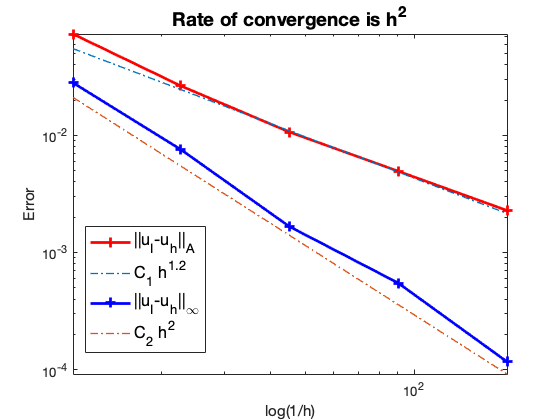

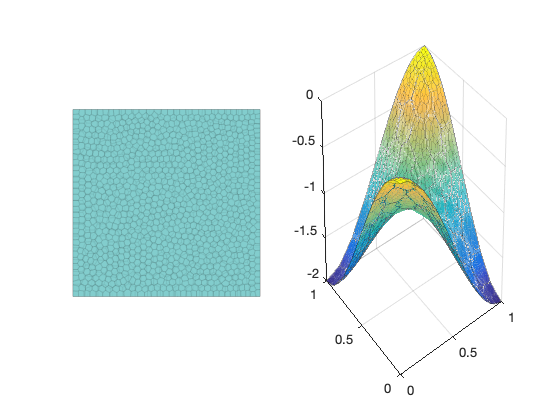

In [16]:
squarePoissonVEM;

## Conclusion

The optimal rate of convergence of the H1-norm (1st order)  of $\|\nabla (u_I - u_h)\|$ and maximum-norm $\| u_I - u_h\|_{\infty}$
(2nd order) is observed. 